# 1. Retrieve and load the Olivetti faces dataset

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

# Fetch the Olivetti faces dataset
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)
X = olivetti.data
y = olivetti.target

# Print the shape of the data
print(X.shape)

(400, 4096)


# 2. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.
TODO: Provide your rationale for the split ratio

In [2]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# I used ratio 60:20:20 for train:val:test respectively
# For I know that there are 40 classes, so I wanted to include at least two of each class in each set
print(X_train.shape, X_val.shape, X_test.shape)

(240, 4096) (80, 4096) (80, 4096)


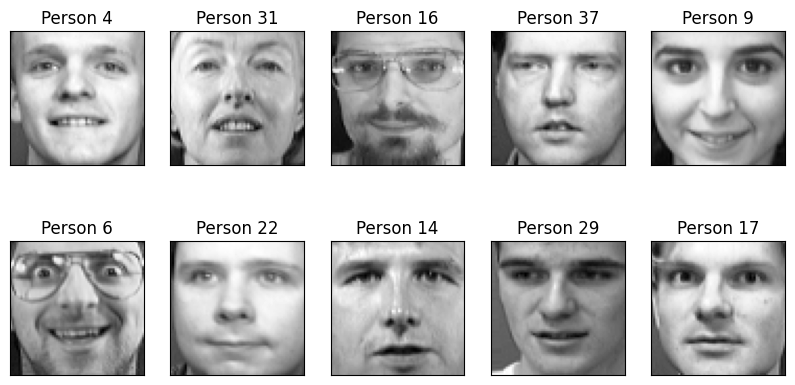

In [3]:
# Display the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(64, 64), cmap='gray')
    ax.set(xticks=[], yticks=[], title=f'Person {y_train[i]}')

# 3. Dimensionality Reduction with K-Means

Optimal number of clusters from K-means: 77


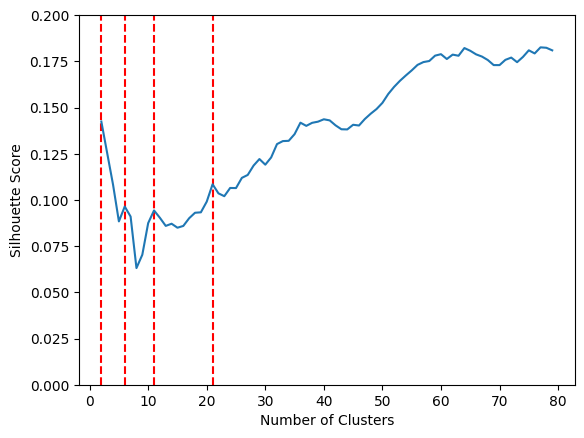

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Find the optimal number of clusters using silhouette score
scores = []
for n_clusters in range(2, 80):
    k = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = k.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    scores.append(score)

# Choose the number of clusters with the highest silhouette score
optimal_clusters = 2 + scores.index(max(scores))
print(f'Optimal number of clusters from K-means: {optimal_clusters}')

# Draw vertical lines
plt.axvline(x=2, c='r', linestyle='--')
plt.axvline(x=6, c='r', linestyle='--')
plt.axvline(x=11, c='r', linestyle='--')
plt.axvline(x=21, c='r', linestyle='--')

# Plot the silhouette scores
plt.plot(range(2, 80), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.ylim((0, 0.2))
plt.show()

For n_clusters=2, the average silhouette_score is 0.14243437349796295
For n_clusters=6, the average silhouette_score is 0.0964057594537735
For n_clusters=11, the average silhouette_score is 0.09430757910013199
For n_clusters=21, the average silhouette_score is 0.10847333073616028


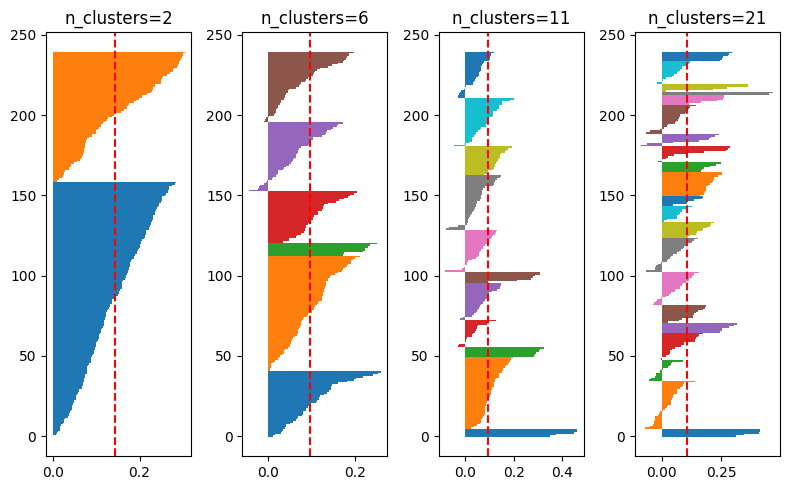

In [5]:
# Silhouette analysis
from sklearn.metrics import silhouette_samples
import numpy as np

n_clusters = [2, 6, 11, 21]
fig, axes = plt.subplots(1, 4, figsize=(8, 5))

models = []
for i in range(len(n_clusters)):
    k = KMeans(n_clusters=n_clusters[i], random_state=42, n_init='auto')
    ax = axes.flat[i]
    labels = k.fit_predict(X_train)
    models.append(k)
    silhouette_values = silhouette_samples(X_train, labels)
    y_ticks = []
    y_lower, y_upper = 0, 0
    for j in range(n_clusters[i]):
        cluster_silhouette_values = silhouette_values[labels == j]
        cluster_silhouette_values.sort()
        y_upper += len(cluster_silhouette_values)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_values)
    silhouette_avg = np.mean(silhouette_values)
    ax.axvline(silhouette_avg, color='red', linestyle='--')
    ax.set_title(f'n_clusters={n_clusters[i]}')
    print(f'For n_clusters={n_clusters[i]}, the average silhouette_score is {silhouette_avg}')

plt.tight_layout()
plt.show()

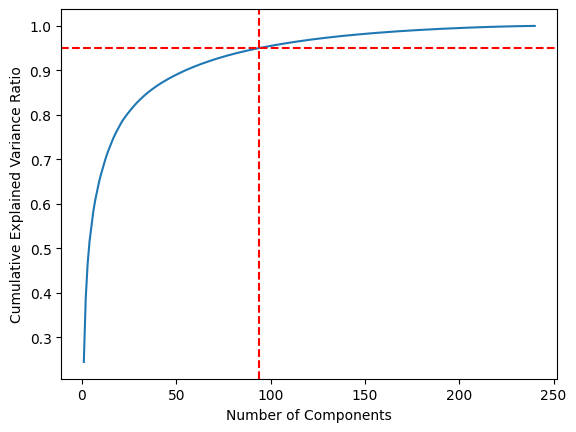

Number of components required to explain 95% of the variance: 94


In [6]:
# Dimensionality reduction
from sklearn.decomposition import PCA

n_cluster = 2

# Fit PCA to the training data
pca = PCA(random_state=42)
pca.fit(X_train)

# Get explained variance ratio
evr = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cum_evr = np.cumsum(evr)

# Plot the explained variance ratio
plt.plot(range(1, len(evr) + 1), cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')

plt.axhline(y=0.95, color='r', linestyle='--')
x0 = np.argmax(cum_evr >= 0.95) + 1
plt.axvline(x=x0, color='r', linestyle='--')
plt.show()

print(f'Number of components required to explain 95% of the variance: {x0}')

(240, 94) (80, 94) (80, 94)


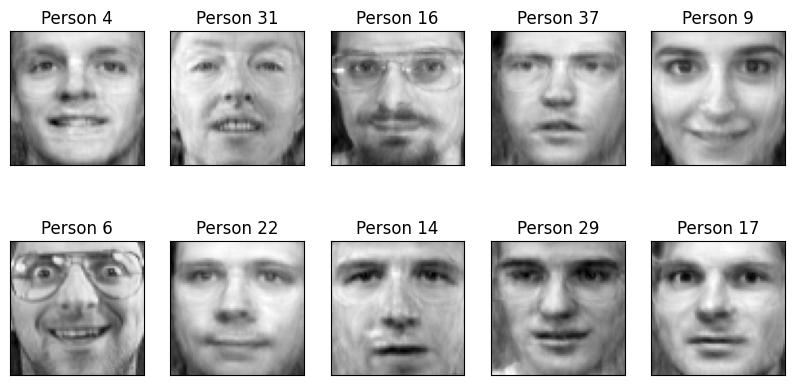

In [7]:
pca = PCA(n_components=x0, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)

# Restore and plot the images
X_train_restored = pca.inverse_transform(X_train_pca)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_restored[i].reshape(64, 64), cmap='gray')
    ax.set(xticks=[], yticks=[], title=f'Person {y_train[i]}')

# 4. Using k-fold cross validation, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.

In [73]:
# Importing required libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Initialize StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=strat_k_fold, scoring='accuracy')

# Calculate mean and standard deviation
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f'CV Accuracy Scores: {cv_scores}')
print(f'Mean of CV Accuracy Scores: {cv_mean}, Standard Deviation of CV Accuracy Scores: {cv_std}')

CV Accuracy Scores: [0.79166667 0.9375     0.91666667 0.9375     0.83333333]
Mean of CV Accuracy Scores: 0.8833333333333332, Standard Deviation of CV Accuracy Scores: 0.05980291706003051


In [9]:
# Evaluate the model on the validation set
clf.fit(X_train_pca, y_train)
val_score = clf.score(X_val_pca, y_val)
print(f'Validation Accuracy Score: {val_score}')

Validation Accuracy Score: 0.95


# 5. Apply DBSCAN algorithm to the Olivetti Faces dataset for clustering.
Preprocess the images and convert them into feature vectors, then use DBSCAN to group similar images together based on their density.

TODO: Provide your rationale for the similarity measure used to perform the clustering, considering the nature of facial image data.

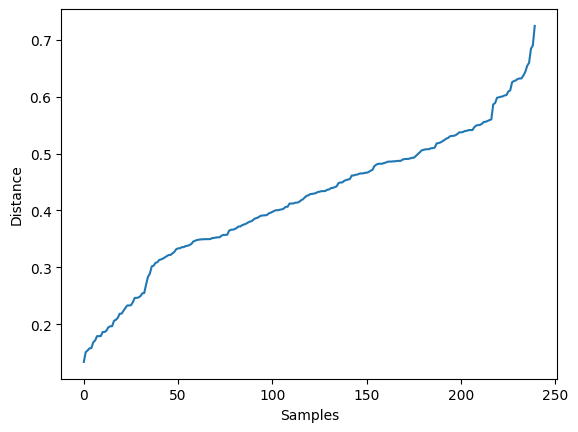

0.13416493 0.7240212 0.4276566803455353


In [23]:
from sklearn.neighbors import NearestNeighbors
from statistics import median

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(X_train_pca)
distances, indices = nn.kneighbors(X_train_pca)

# Sort and plot the distances
distances = np.sort(distances[:, -1], axis=0)
plt.plot(distances)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# There is no clear knee in the curve

print(distances.min(), distances.max(), median(distances))

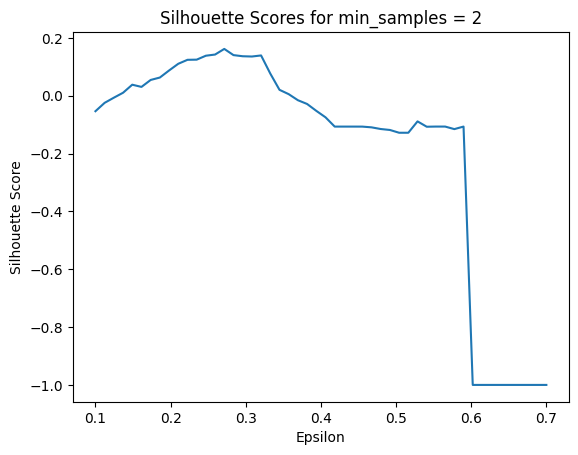

Best eps: 0.27142857142857146, Best min_samples: 2, Best silhouette score: 0.1619361788034439, Number of clusters: 57


In [44]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables
best_eps = 0
best_min_samples = 0
best_silhouette_score = -1
best_n_clusters = 0

# Dictionary to store silhouette scores for plotting
silhouette_scores = {}

eps_values = np.linspace(0.1, 0.7, 50)
min_samples_values = range(2, 10)

for min_samples in min_samples_values:
    silhouette_scores[min_samples] = []
    
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine', n_jobs=-1)
        cluster_labels = dbscan.fit_predict(X_train_pca)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        # Skip the bad clustering
        if n_clusters <= 1:
            silhouette_scores[min_samples].append(-1)
            continue
        
        # Compute the silhouette score
        silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
        silhouette_scores[min_samples].append(silhouette_avg)
        
        # Update the best score, eps, and min_samples
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples
            best_n_clusters = n_clusters

# Plotting silhouette scores for the best min_samples
plt.figure()
plt.plot(eps_values, silhouette_scores[best_min_samples])
plt.title(f"Silhouette Scores for min_samples = {best_min_samples}")
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Score")
plt.show()

print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_silhouette_score}, Number of clusters: {best_n_clusters}")

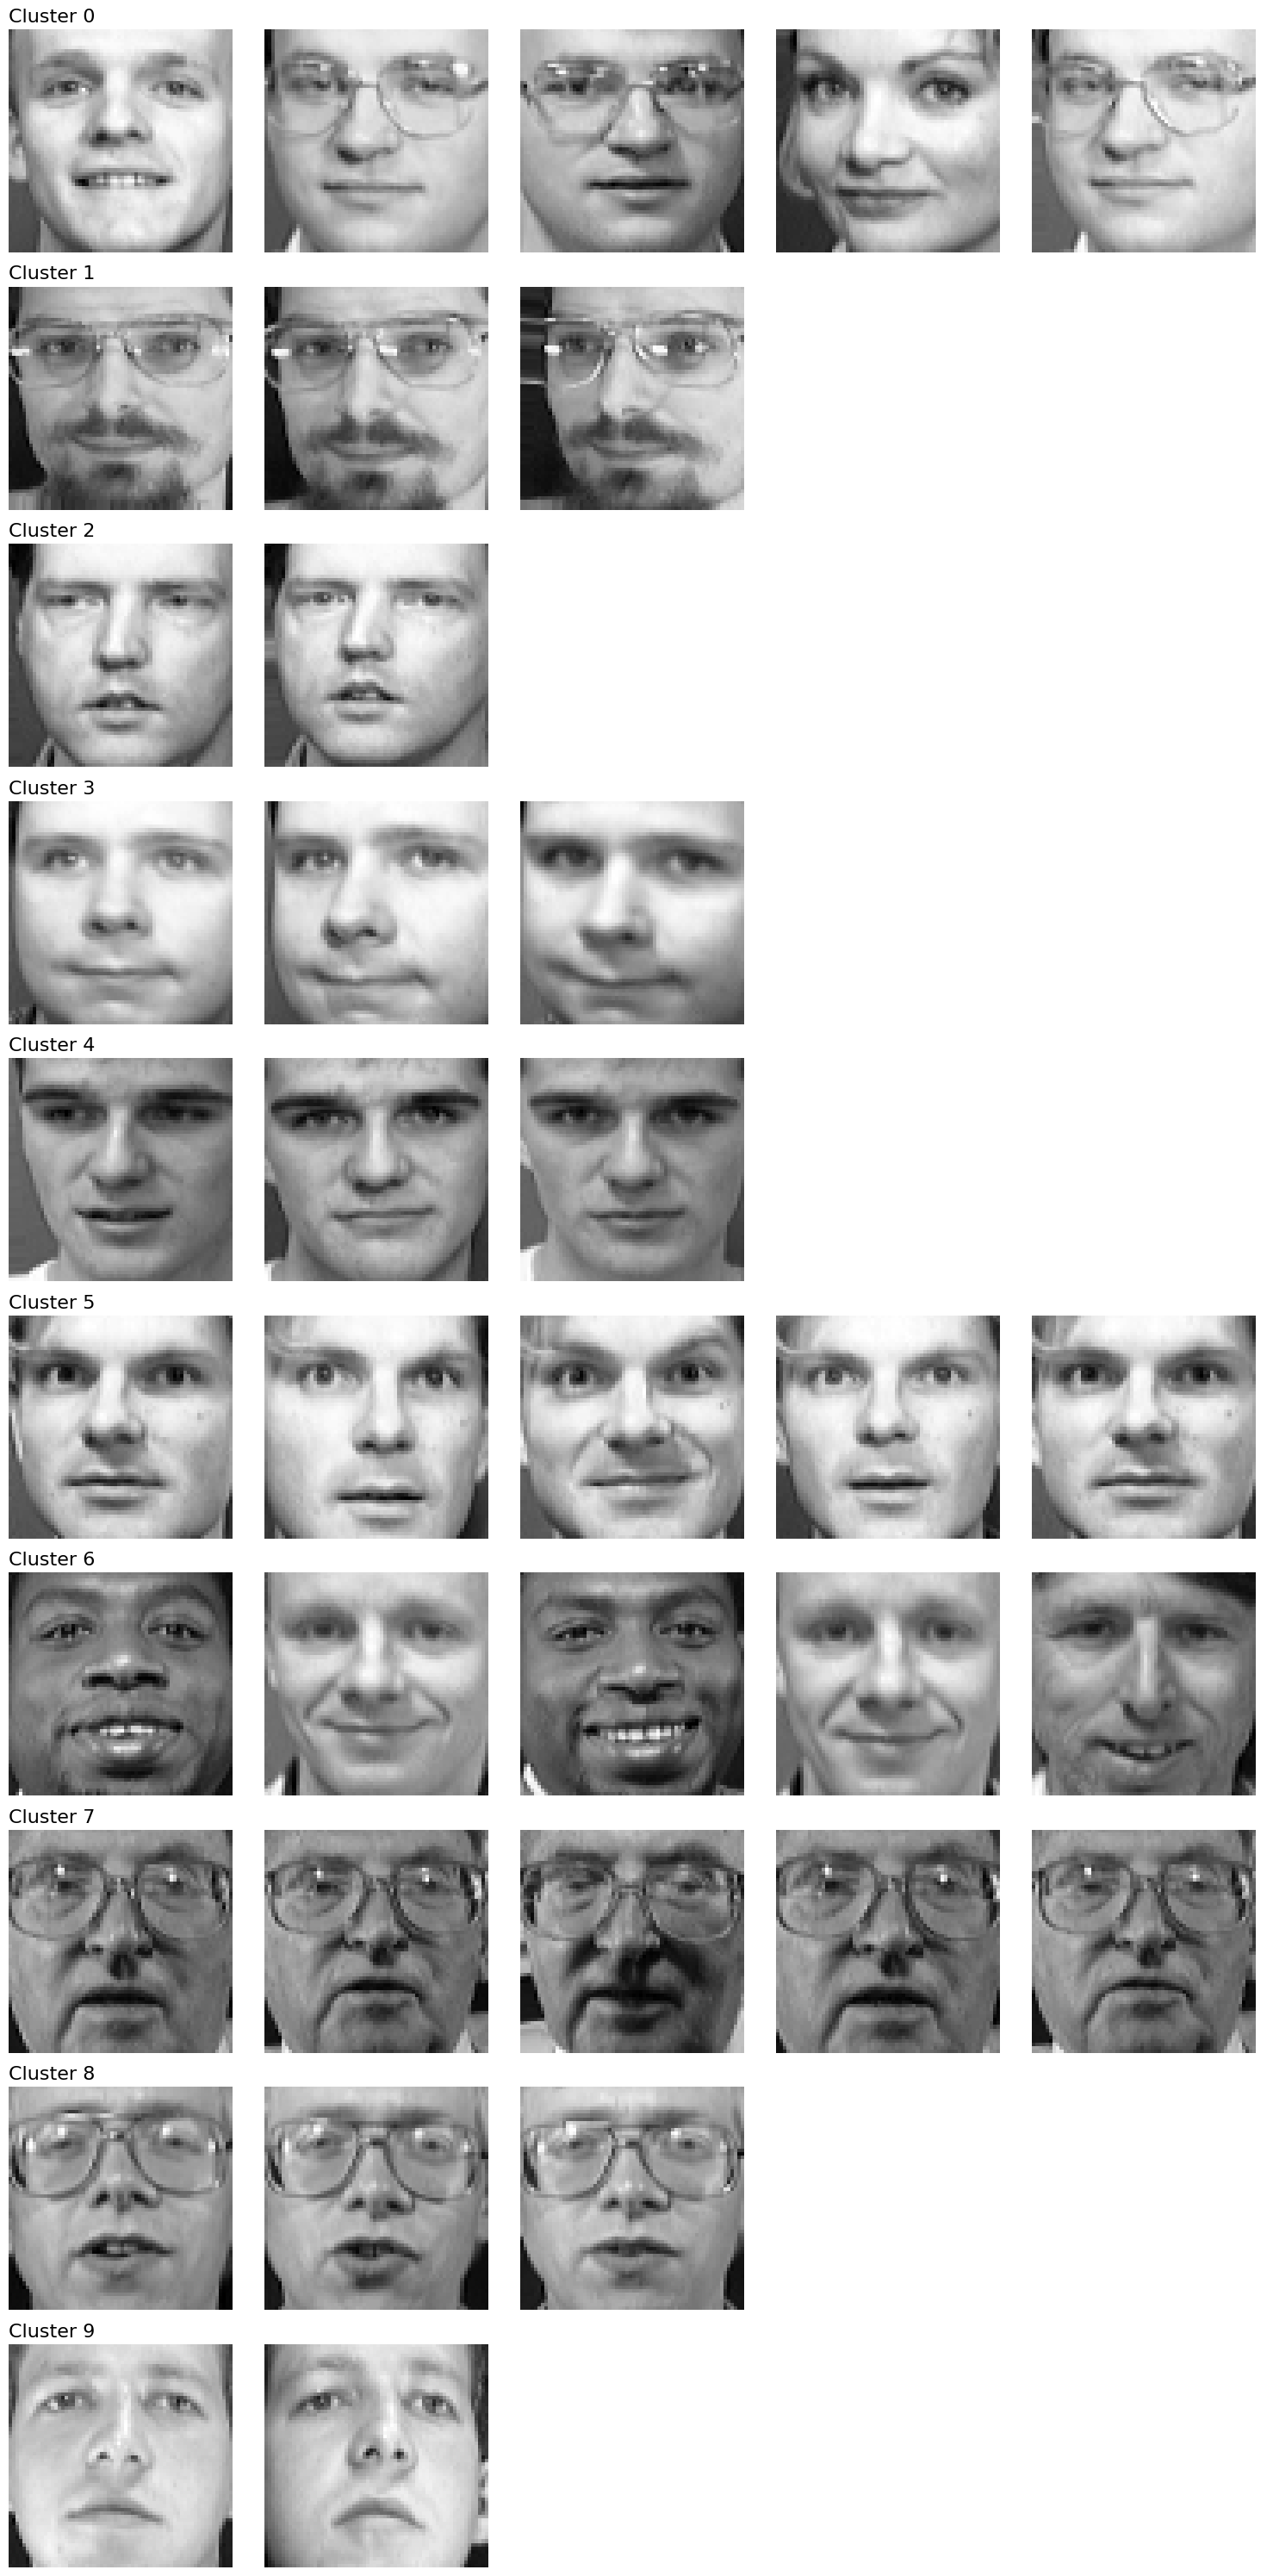

In [70]:
import matplotlib.pyplot as plt

# Re-run DBSCAN with the best eps and min_samples values
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine', n_jobs=-1)
cluster_labels = dbscan.fit_predict(X_train_pca)

# Create a dictionary to hold images of each cluster
image_by_cluster = {}
for idx, label in enumerate(cluster_labels):
    if label == -1:  # Skip noise points
        continue
    if label not in image_by_cluster:
        image_by_cluster[label] = []
    image_by_cluster[label].append(X_train[idx])

# Plot images from the first 10 clusters
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))

# Only taking first 10 clusters for plotting
for i, cluster_id in enumerate(sorted(image_by_cluster.keys())[:10]):
    imgs = image_by_cluster[cluster_id][:5]  # Take up to 5 images from this cluster
    for j in range(5):
        ax = axes[i, j]
        if j < len(imgs):
            ax.imshow(imgs[j].reshape(64, 64), cmap='gray')
        ax.axis('off')

    # Write cluster ID for each row
    axes[i, 0].set_title(f'Cluster {cluster_id}', loc='left', fontsize=16)

plt.tight_layout()
plt.show()